## Assignment 3

> This is part of the course Mining Software Repositroies
>
> 👩‍💻 by: Amir Reza Javaher Dashti (javaher@uni-koblenz.de)
>

The goal of assignment 3 is to callout and address a threat to validity. In previous parts of this work we have seen the threat and general suggestion of how to address it. Here, we will go through hypothesis formation step-by-step, then apply statistical calculations, and borrow tools from Data Science to prove our points:


### Part 1: Hypothesis

#### Our hypothesis based on information we have about the paper is as follows:


H0: Executing tests more than 100 times will not result in finding significantly more flaky tests.

Ha: Alternative Hypothesis claims 100 is not close to ideal and there is possible to find an optimal re-run threshold that results in finding signfincantly more flaky tests.


----
Assumed CI= 99%, 

n = 571


Total number of tests used in this study is : 56980. This is our population size.

If we assume reaching Confidence Interval close to ± 99% is possible having roughly 571 (1%)  would be enough.

### Part 2: Underlaying Statistical Model

A) Corrected Threshold:

Three-sigma rule of thumb is an empirically heuristic that calims it is practically impossible to have random sample from a normal distribution that has a distance of more than 3 times standard deviation from population mean (average) [1]. In simple words, since we know our population (which is the count of re-runs until falky behavior is observed), we can calculate mean and sigma and hence calculate the threshold of values which is mean + 3 * sigma.

This is of course not caliming that our statistical threshold is a global optimum rather we are trying to show you that the chosen number of 100 re-runs might be invalid (we will see in testing section).


![title](./../doc/3sigma.png)


[1] reference: https://encyclopediaofmath.org/wiki/Three-sigma_rule


B) Calculate Threshold:

In [1]:
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import scipy.stats as stats
import numpy as np

all_reruns = pd.read_csv('./../data/input/ez_mode/' + 'all_reruns.csv')

# choose flaky test cases only
flaky_tests = all_reruns[all_reruns['flaky'] == True]

flaky_tests.head(10)

,dir,test,first_result,frequency,flaky
353,alluxio.client.cli.fs.JobServiceFaultTolerance...,distributedMv,pass,12,True
359,alluxio.client.cli.JournalToolTest,dumpHeapCheckpointFromEmbeddedJournal,fail,2,True
599,alluxio.client.fs.FreeAndDeleteIntegrationTest,deleteDir,pass,12,True
927,alluxio.server.ft.journal.JournalBackupIntegra...,backupDelegationProtocol,pass,2,True
932,alluxio.server.ft.journal.JournalBackupIntegra...,backupRestoreZk,error,2,True
933,alluxio.server.ft.journal.JournalBackupIntegra...,backupRestoreEmbedded,error,2,True
947,alluxio.server.ft.journal.raft.EmbeddedJournal...,restartStress,error,2,True
948,alluxio.server.ft.journal.raft.EmbeddedJournal...,growCluster,error,2,True
949,alluxio.server.ft.journal.raft.EmbeddedJournal...,failover,error,2,True
950,alluxio.server.ft.journal.raft.EmbeddedJournal...,restart,error,2,True


In [2]:
# Calculate Population Mean and Standard Deviation:


mean = statistics.mean(flaky_tests['frequency'])
variance = statistics.pvariance(flaky_tests['frequency'])
sigma = math.sqrt(variance)

# find the max re-execution threshold with assumption of normal distribution:
threshold = round(mean + 3 * sigma)


print('Mean: ', mean)
print('Standard Deviation: ', sigma)
print('Corrected threshold for re-runs: ', threshold)

Mean:  42.174418604651166
Standard Deviation:  40.31567063910241
Corrected threshold for re-runs:  163


Emprically speaking, with the assumption that the test falkiness follow a Normal Distribution, we conclude that since it is highly unlikely to see a flaky behavior after ± 163 reruns. As a result, this would be our new max threshold. We will now need a sample to see if we run them up to 163 times can they be significantly different from the population recorded using 100 test re-runs.

C) Flaky Sample Distribution:

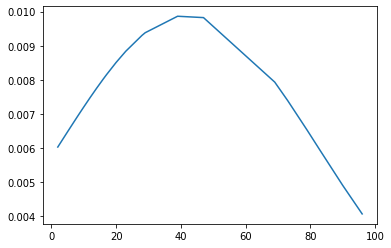

In [3]:
# draw distribution

histogram_data = list(flaky_tests['frequency'])
histogram_data.sort()
pdf = stats.norm.pdf(histogram_data, mean, sigma)
plt.plot(histogram_data, pdf)

# Plot with original data:

The distribution of our population memebers, as we guessed, is very close distribution of a Guassian Distribution. This confirms the general idea we had about changing the threshold. In the next part we will test and try to nullify the hypothesis formed on top of that.

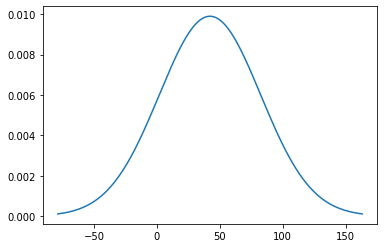

In [4]:
x = np.linspace(mean - 3 * sigma, mean + 3 * sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mean, sigma))
plt.show()

# Plotting ideal distribution based on Mean and Standard Deviation

### Part 3: Testing Hypothesis (Nullifying)

We would like to know if flaky behavior ,as claimed in the paper's threats to validity, can be significantly changed if we use a better threshold for re-running a test. The idea is to run a test multiple times in order to see if it switches behavior (a passing test suddenly changes without change of environment, inputs and code or a failing test suddenly passes in the same way). So far, I have suggested that we use threshold of the distribution ( mean + 3 sgima) as the max re-execuations.

This means we try re-executing each test up-to this number. As soon as we observe flakiness it is tagged as flaky and we collect the number. If we never could observe flakiness up-to our new threshold we assume (just like original work) that this is a non-flaky test case.


In assigment 2, I have provided base docker file and cloning capacity of all tests. Unfortunately, becasue it is too deep in Java classes and SDK I had to do it manually. Following part uses this sampling. Samples are selected randomly by ./process/generator.py:

In [5]:
sample_reruns = pd.read_csv('./../data/input/ez_mode/' + 'sample_runs.csv')

# correct the sample only for flaky samples
sample_tests = sample_reruns[sample_reruns['flaky']]


sample_tests.head(10)

,dir,test,first_result,frequency,flaky,sample_run
4,org.apache.hadoop.log.TestLogThrottlingHelper,testNamedLoggersWithoutSpecifiedPrimary,pass,100,True,114
7,org.apache.hadoop.security.token.delegation.we...,testAuthenticate,pass,100,True,151
22,org.apache.jackrabbit.oak.security.user.query....,testRowToUserSubTree,pass,100,True,109
23,org.apache.hc.core5.http2.impl.io.TestFrameInO...,testReadEmptyFrame,pass,100,True,126
24,org.apache.jackrabbit.oak.security.user.UserIm...,testHandleDisabledMvPropertyDef,pass,100,True,131
25,org.springframework.boot.autoconfigure.thymele...,useJava8TimeDialect,pass,100,True,77
30,org.apache.jackrabbit.oak.plugins.document.bun...,exactName,pass,100,True,161
33,org.apache.oozie.fluentjob.api.dag.TestDecisio...,testAddParentWhenSomeAlreadyExist,pass,100,True,12
62,org.springframework.boot.actuate.metrics.cache...,ehCache2CacheProvider,pass,100,True,63
66,ro.isdc.wro.model.resource.locator.TestUrlUriL...,testValidUrl,pass,100,True,121


In [9]:
# We calculate Z-score to compare it with the P of our Confidence Interval

sample_mean = statistics.mean(sample_tests['sample_run'])
sample_sigma = math.sqrt(statistics.variance(sample_tests['sample_run']))

z = ( sample_mean - mean ) / (sigma * sigma/ math.sqrt(len(sample_tests)))

print('Z-Score of our samples: ', z)

print (sample_mean)
print (sample_sigma)
possible_ci_for_z = stats.norm.cdf(z)

print('Max Confidence Interval Given the Z: ', round(possible_ci_for_z, 2), '%')

Z-Score of our samples:  0.2879693443906122
110.44680851063829
42.318568496500085
Max Confidence Interval Given the Z:  0.61 %


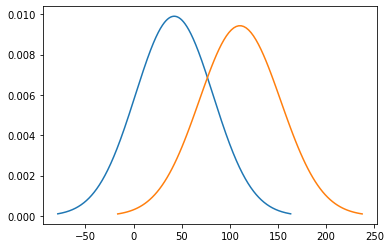

In [7]:
x = np.linspace(mean - 3 * sigma, mean + 3 * sigma, 1000)
mp.plot(x, stats.norm.pdf(x, mean, sigma))
y = np.linspace(sample_mean - 3 * sample_sigma, sample_mean + 3 * sample_sigma, 100)
mp.plot(y, stats.norm.pdf(y, sample_mean, sample_sigma))

mp.show()


# here we compare the population distribution VS sample distribution:

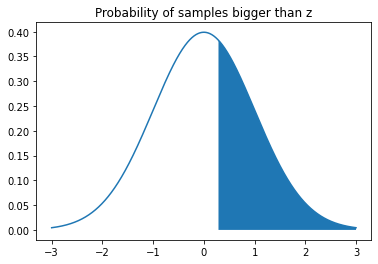

In [8]:
def draw_z_score(x, cond, mu, sigma, title):
    y = stats.norm.pdf(x, mu, sigma)
    z = x[cond]
    plt.plot(x, y)
    plt.fill_between(z, 0, stats.norm.pdf(z, mu, sigma))
    plt.title(title)
    plt.show()
    

x = np.arange(-3,3,0.001)
z0 = z
draw_z_score(x, x > z0, 0, 1, 'Probability of samples bigger than z')

### Summary:

This was an statistical investigation about the threat to validity in the paper's initial flaky sampling criteria. We have formed a hypothesis claiming that based on the exiting data it seems very unlikely that the 100 re-executions is a good detector of flaky behavior. With assumption of a Gaussian distribution, next we have introduced a new threshold. Using this new threshold we did a new sampling. After running the tests we have compared these 2 distributions and calculated the Z-score.


Unfortunately, we can not say with 99% confidence that our sampling results in significant deviation from original population however with the known value of z we have re-estimated the confidence interval. 


The calculated value of "Max Confidence Interval Given the Z" shows that we are only 61% sure that the null hypothesis is wrong and the threat to validity exists. This is the end of my investigations, we can improve this work by adding re-shuffled sampling and heavier testing or using a more descriptive gaussian model (than the normal one which I have used for simplicity).